In [1]:
# Standard modules
import numpy as np
import pandas as pd
import re
import nltk
import enchant
import wordninja
import unidecode as ud
import matplotlib.pyplot as plt
from modules.contractions import contractions_dict
# Twitter tagger APIs
from modules.CMUTweetTagger import runtagger_parse

# Matplotlib setup
%matplotlib inline

In [2]:
# Constants

# Path to POS tagger java application
ARK_TWEET_NLP_PATH = 'java -XX:ParallelGCThreads=2 -Xmx500m -jar resources/ark-tweet-nlp-0.3.2/ark-tweet-nlp-0.3.2.jar'

# Path to words dataset .csv file
WORDS_PATH = 'data/words.csv'

# Define the American English set of allowed words
en_dict = enchant.Dict("en_US")

In [3]:
# DATI GRETA
tweets = []
for period in ['pre', 'post']:
    tweets.append(pd.read_json('data/tweets_{}Greta.json'.format(period)))
    
tweets[1].head()

,created_at,id,text,retweet_count,favorite_count,original_retweet_count,original_favorite
0,2019-03-02 09:14:52+00:00,1101772852863340544,Extinction @ExtinctionR are right. Only radic...,0,1,NaN,NaN
1,2019-03-02 09:14:52+00:00,1101772852586409988,“We only have 12 years to fix this” is the mos...,0,0,227.0,1038.0
2,2019-03-02 09:14:50+00:00,1101772843694608384,Our voices are loud &amp; clear. We need #Clim...,0,0,438.0,1413.0
3,2019-03-02 09:14:49+00:00,1101772840980832256,@MeganMcCubbin @HouseofCommons @CarolineLucas ...,0,0,25.0,55.0
4,2019-03-02 09:14:42+00:00,1101772811763412992,We're thanking people working on the climate c...,0,0,55.0,332.0


In [4]:
# Splitting hashtag
def split_hashtag(hashtag):
    hash_words = wordninja.split(hashtag)
    
    for word in hash_words:
        if en_dict.check(word) == False:
            return []
    
    return hash_words



# cleaning part
def clean_hashtags(row):
    tweet = row.text.split(" ")
    
    for i, word in enumerate(tweet):
        if "#" in word:
            # Initialize the hashtag
            tweet[i] = " "
            # Extract eventually stacked hashtags
            for hashtag in word.split("#")[1:]:
                h_words = split_hashtag(hashtag)
                tweet[i] = tweet[i].join(h_words)
            
    row.text = " ".join(tweet)
    return row

In [5]:
## test 
tweets = tweets[1]

# Format hashtags
tweets_clean = tweets.apply(clean_hashtags, axis=1)

tweets_clean.head()

,created_at,id,text,retweet_count,favorite_count,original_retweet_count,original_favorite
0,2019-03-02 09:14:52+00:00,1101772852863340544,Extinction @ExtinctionR are right. Only radic...,0,1,NaN,NaN
1,2019-03-02 09:14:52+00:00,1101772852586409988,“We only have 12 years to fix this” is the mos...,0,0,227.0,1038.0
2,2019-03-02 09:14:50+00:00,1101772843694608384,Our voices are loud &amp; clear. We need Clima...,0,0,438.0,1413.0
3,2019-03-02 09:14:49+00:00,1101772840980832256,@MeganMcCubbin @HouseofCommons @CarolineLucas ...,0,0,25.0,55.0
4,2019-03-02 09:14:42+00:00,1101772811763412992,We're thanking people working on the climate c...,0,0,55.0,332.0


In [6]:
# Define wrapper function for POS tagging words in tweets
def pos_tag(tweets):
    return runtagger_parse(tweets, run_tagger_cmd=ARK_TWEET_NLP_PATH)

In [7]:
# Tag each tweet in dataset
tagged_tweets = pos_tag(tweets_clean.loc[:, 'text'].values)
tagged_tweets[:3]

[[('Extinction', 'N', 0.9425),
  ('@ExtinctionR', '@', 0.9962),
  ('are', 'V', 0.9954),
  ('right', 'A', 0.6918),
  ('.', ',', 0.999),
  ('Only', 'R', 0.9474),
  ('radical', 'A', 0.9139),
  ('disruptive', 'A', 0.988),
  ('action', 'N', 0.9994),
  ('is', 'V', 0.9939),
  ('going', 'V', 0.986),
  ('to', 'P', 0.9769),
  ('have', 'V', 0.9999),
  ('any', 'D', 0.9957),
  ('effect', 'N', 0.9854),
  ('.', ',', 0.9984),
  ('Corporate', 'A', 0.7158),
  ('and', '&', 0.9973),
  ('elite', 'A', 0.5535),
  ('interests', 'N', 0.9982),
  ('have', 'V', 0.9987),
  ('railroaded', 'V', 0.7605),
  ('through', 'P', 0.9177),
  ('terribly', 'R', 0.9908),
  ('destructive', 'A', 0.9968),
  ('economic', 'A', 0.7261),
  ('policy', 'N', 0.9996),
  ('.', ',', 0.9977),
  ('Climate', 'N', 0.8914),
  ('Crisis', 'N', 0.9795),
  ('https://t.co/txD9fp1spt', 'U', 0.9917)],
 [('“', ',', 0.9724),
  ('We', 'O', 0.9954),
  ('only', 'R', 0.9465),
  ('have', 'V', 0.9898),
  ('12', '$', 0.9974),
  ('years', 'N', 0.9965),
  ('to', 

In [8]:
# Turn each tuple into a dictionary

# Define new list containing tagged words
tagged_words = list()
# Loop through each tagged tweet
for i, tagged_tweet in enumerate(tagged_tweets):
    # Get current tweet id
    tweet_id = tweets.loc[i, 'id']
    # Loop through each tag in current tweet
    for j, tag in enumerate(tagged_tweet):
        # Overwrite tag tuple with word dictionary
        tagged_word = {
            'tweet': tweet_id, # Id of tweet containing word
            'index': j, # Word index in sentence
            'text': tag[0], # Actual word text
            'pos': tag[1], # Part Of Speech tag
            'conf': tag[2], # Confidence for POS tag
        }
        # Update tagged words list
        tagged_words.append(tagged_word)
    
# Turn tagged words list into a Pandas DataFrame object
words = pd.DataFrame(tagged_words)
words.head()

,tweet,index,text,pos,conf
0,1101772852863340544,0,Extinction,N,0.9425
1,1101772852863340544,1,@ExtinctionR,@,0.9962
2,1101772852863340544,2,are,V,0.9954
3,1101772852863340544,3,right,A,0.6918
4,1101772852863340544,4,.,",",0.9990


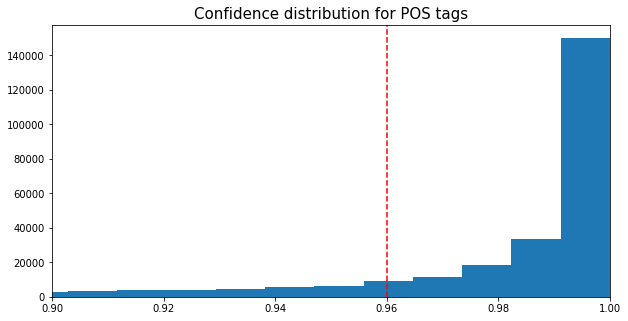

In [9]:
# Plot distribution of the confidence
fig, ax = plt.subplots(figsize=(10, 5))
_ = ax.set_title('Confidence distribution for POS tags',fontsize=15)
_ = ax.hist(words.conf, bins=100)
_ = ax.set_xlim(left=0.9, right=1.0)
_ = ax.axvline(x=0.96, c='r', ls='--')
# _ = plt.savefig('images/preprocessing/tag_conf.png')
_ = plt.show()

In [10]:
# Define confindence limit
conf = 0.96

print('There are {:d} ({:.02f}%) words under {:.2f} confidence interval'.format(
    sum(words.conf < conf), sum(words.conf < conf) / words.shape[0] * 100, conf
))

print('There will be {:d} ({:.02f}%) words remaining inside {:.2f} confidence interval'.format(
    sum(words.conf >= conf), sum(words.conf >= conf) / words.shape[0] * 100, conf
))

There are 91738 (29.56%) words under 0.96 confidence interval
There will be 218594 (70.44%) words remaining inside 0.96 confidence interval


In [11]:
# Remove tags whose POS tag confidence is below 0.96
words = words[words.conf >= conf]

# Keep only nouns (N), verbs (V), adverbs (R), adjectives (A), pronoun (O) and nominal+verbal (L)
words = words[words.pos.isin(['N', 'V', 'R', 'A', 'O', 'L'])]

In [12]:
# Clean hashtags from punctuation (the will be matched with words)
words.text = words.text.apply(lambda x: re.sub(r'[#]', '', x))
words.text = words.text.apply(lambda x: re.sub(r'^[-]*', '', x))
words.text = words.text.apply(lambda x: re.sub(r'[-]*$', '', x))
words.tail()

,tweet,index,text,pos,conf
310316,1137447019042222080,36,it,O,0.9969
310317,1137447019042222080,37,goes,V,0.9973
310327,1137447019042222080,47,climate,N,0.9875
310329,1137447019042222080,49,Conservation,N,0.9841
310330,1137447019042222080,50,Optimism,N,0.9968


In [13]:
words[words.text == '-icon']

,tweet,index,text,pos,conf


In [14]:
pronouns = ['I', 'you', 'it', 'she', 'he', 'we', 'they', 
            'me', 'her', 'hers', 'him', 'us', 'them', 
            'my', 'your', 'yours', 'his', 'its', 'our', 'ours', 'their',
            'myself', 'yourself', 'himself', 'herself', 'itself', 'ourselves', 'yourselves']

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')


# Lowercase all and remove stopwords
words.text = words.text.apply(lambda x: x.lower())  # Lowercase
words = words[~words.text.isin(set(stopwords) - set(pronouns))]  # Stopwords removal
words.shape

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(91098, 5)

In [15]:
nltk.download('wordnet')
wnl = nltk.stem.WordNetLemmatizer()

def lemmatize(x):
    # pronouns don't need lemmatization
    if x.pos in ['L', 'O']:
        return x.text
    else:
        return wnl.lemmatize(x.text, x.pos.lower())

# Lemmatize words
words.text = words.apply(lemmatize, axis=1)
words.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,tweet,index,text,pos,conf
7,1101772852863340544,7,disruptive,A,0.9880
8,1101772852863340544,8,action,N,0.9994
10,1101772852863340544,10,go,V,0.9860
14,1101772852863340544,14,effect,N,0.9854
19,1101772852863340544,19,interest,N,0.9982


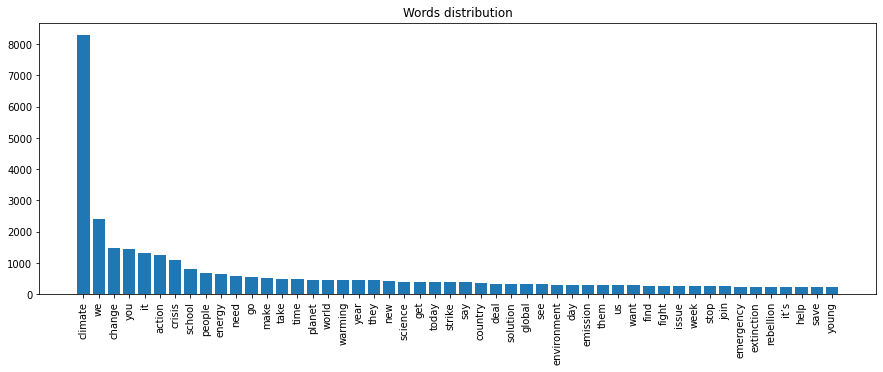

In [16]:
word_counts = words.text.value_counts()
word_counts = word_counts[:50]

# Plot words count
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.set_title('Words distribution')
_ = ax.bar(x=word_counts.keys().tolist(), height=word_counts.tolist())
_ = ax.tick_params(axis='x', rotation=90)
_ = plt.plot()

In [17]:
# Convert punctuation
words.text = words.apply(lambda x: ud.unidecode(x.text), axis=1)
words.shape

(91098, 5)

In [18]:
def decontract(x):
    if x.text.lower() in contractions_dict.keys():
        return contractions_dict[x.text.lower()]
    else: return x.text
    
    

def cleaning(x):
  
    # extract pronouns, change tag and conf = 1
    w = x.text.split()
    for y in w:
        if y in pronouns:
            return [y, 'O', 1]
        
    # ignore composite words
    return [x.text, x.pos, x.conf]

In [19]:
# Manage contractions
words.text = words.apply(decontract, axis=1)
contr_mask = words.text.isin( list(contractions_dict.keys()) )

# Identify remaining entries with symbols
symb_mask = words.text.apply(lambda x: len(re.findall(r'[^\w-]', x))) != 0

# Apply cleaning
words.loc[ symb_mask, ['text', 'pos', 'conf'] ] = words.loc[symb_mask, ['text', 'pos', 'conf']].apply(
    cleaning, axis = 1).values.tolist()

# Show results
words.loc[ symb_mask, ['text', 'pos', 'conf'] ].head()

,text,pos,conf
146,is not,V,0.9974
870,that is,L,0.9930
1408,does not,V,0.9934
1431,we,O,1.0000
1693,I,O,1.0000


In [20]:
# symb_mask = words.text.apply(lambda x: len(re.findall(r'[^\w-]', x))) != 0
# print(words.loc[symb_mask, 'text'].values.tolist())

In [21]:
# Remove stopwords

def stop_finder(x):
    w = x.split()
    for y in w:
        if y in set(stopwords) - set(pronouns): 
            return False
        
    return True
        
words = words[words.text.apply(stop_finder)]

In [22]:
# symb_mask = words.text.apply(lambda x: len(re.findall(r'[^\w-]', x))) != 0
# print(words.loc[symb_mask, 'text'].values.tolist())

In [23]:
# Drop entries with symbols
words = words.loc[words.text.apply(lambda x: len(re.findall(r'[^\w-]', x))) == 0]

In [24]:
# Output to file
words.to_csv(WORDS_PATH, index=False)